In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from PIL import Image  
from tqdm import tqdm

In [2]:
# Read Dataset Custom: 
class RiceDiseaseDataset(Dataset):
    def __init__(self, csv_file, base_path, transform=None, verbose=True):
        self.data = pd.read_csv(csv_file)
        self.base_path = base_path
        self.transform = transform
        self.label_mapping = {label: idx for idx, label in enumerate(self.data['label'].unique())}
        
        # Store valid image paths
        self.valid_data = []
        for _, row in self.data.iterrows():
            img_name = row['image_id']
            label = row['label']
            
            # Check in label subdirectory
            potential_path = os.path.join(self.base_path, label, img_name)
            if os.path.exists(potential_path):
                self.valid_data.append({
                    'image_path': potential_path,
                    'label': label
                })
        
        # Print dataset information if verbose is True
        if verbose:
            print(f"Number of classes: {len(self.label_mapping)}")
            print("Label mapping:", self.label_mapping)
            print(f"Found {len(self.valid_data)} valid images")
    
    def __len__(self):
        return len(self.valid_data)

    def __getitem__(self, idx):
        item = self.valid_data[idx]
        img = Image.open(item['image_path']).convert('RGB')
        label = self.label_mapping[item['label']]
        
        if self.transform:
            img = self.transform(img)
            
        return img, label


In [3]:
# Custom RiceNet Model: Marge Resnet With DenceNet

class CustomRiceNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomRiceNet, self).__init__()
        
        # Feature extractors
        self.resnet_features = models.resnet18(weights='IMAGENET1K_V1')  # Updated pretrained parameter
        resnet_out = self.resnet_features.fc.in_features
        self.resnet_features.fc = nn.Identity()
        
        self.densenet_features = models.densenet121(weights='IMAGENET1K_V1')  # Updated pretrained parameter
        densenet_out = self.densenet_features.classifier.in_features
        self.densenet_features.classifier = nn.Identity()
        
        combined_features = resnet_out + densenet_out
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(combined_features, 512),
            nn.ReLU(),
            nn.Linear(512, 1),  # Changed to output single attention weight
            nn.Sigmoid()
        )
        
        # Feature fusion layers
        self.fusion = nn.Sequential(
            nn.Linear(combined_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Final classification layer
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        # Extract features from both networks
        resnet_out = self.resnet_features(x)
        densenet_out = self.densenet_features(x)
        
        # Concatenate features
        combined_features = torch.cat((resnet_out, densenet_out), dim=1)
        
        # Apply attention
        attention_weights = self.attention(combined_features)
        weighted_features = combined_features * attention_weights
        
        # Fuse features
        fused_features = self.fusion(weighted_features)
        
        # Final classification
        output = self.classifier(fused_features)
        
        return output

In [4]:
# Loss Calculation:

class CustomRiceLoss(nn.Module):
    def __init__(self):
        super(CustomRiceLoss, self).__init__()
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, outputs, targets):
        return self.criterion(outputs, targets)

In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50):
    best_val_loss = float('inf')
    training_history = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for inputs, targets in tqdm(train_loader, desc='Training'):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc='Validation'):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total

        # Print epoch results
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc
            }, 'best_custom_rice_model.pth')

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Store results
        training_history.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        })

    return training_history

In [6]:
def main():
    # Set random seed
    torch.manual_seed(42)
    
    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define transforms
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    csv_file = '/kaggle/input/paddydoctor/train.csv'
    base_path = '/kaggle/input/paddydoctor/train_images'

    # Create full dataset and print information
    full_dataset = RiceDiseaseDataset(csv_file=csv_file, base_path=base_path, transform=None, verbose=True)

    # Split indices
    train_indices, val_indices = train_test_split(
        range(len(full_dataset)),
        test_size=0.2,
        random_state=42
    )

    # Create train and validation datasets without printing
    train_dataset = RiceDiseaseDataset(csv_file=csv_file, base_path=base_path, transform=train_transforms, verbose=False)
    val_dataset = RiceDiseaseDataset(csv_file=csv_file, base_path=base_path, transform=val_transforms, verbose=False)

    # Create subsets
    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(val_dataset, val_indices)

    # Create dataloaders
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2)

    # Initialize model
    model = CustomRiceNet(num_classes=len(full_dataset.label_mapping))
    model = model.to(device)

    # Initialize loss and optimizer
    criterion = CustomRiceLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=3, verbose=True
    )

    # Train the model
    training_history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        num_epochs=80
    )

    # Save training history
    pd.DataFrame(training_history).to_csv('training_history.csv', index=False)

    return full_dataset, model, val_loader, device  # Return these objects

if __name__ == '__main__':
    full_dataset, model, val_loader, device = main()

Using device: cuda
Number of classes: 10
Label mapping: {'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}
Found 10407 valid images


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 185MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 153MB/s] 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/80


Validation: 100%|██████████| 66/66 [00:12<00:00,  5.47it/s]


Train Loss: 1.9621 | Train Acc: 30.70%
Val Loss: 1.8396 | Val Acc: 37.13%

Epoch 2/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.31it/s]


Train Loss: 1.6985 | Train Acc: 41.79%
Val Loss: 1.4819 | Val Acc: 44.86%

Epoch 3/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.43it/s]


Train Loss: 1.5292 | Train Acc: 47.99%
Val Loss: 1.3305 | Val Acc: 53.79%

Epoch 4/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.25it/s]


Train Loss: 1.3713 | Train Acc: 52.79%
Val Loss: 1.2996 | Val Acc: 55.28%

Epoch 5/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.44it/s]


Train Loss: 1.2268 | Train Acc: 57.96%
Val Loss: 1.0028 | Val Acc: 67.48%

Epoch 6/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.37it/s]


Train Loss: 1.1534 | Train Acc: 61.15%
Val Loss: 1.0192 | Val Acc: 63.74%

Epoch 7/80


Validation: 100%|██████████| 66/66 [00:11<00:00,  5.88it/s]


Train Loss: 1.0802 | Train Acc: 63.90%
Val Loss: 0.9081 | Val Acc: 68.59%

Epoch 8/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.00it/s]


Train Loss: 0.9879 | Train Acc: 66.64%
Val Loss: 0.8344 | Val Acc: 71.47%

Epoch 9/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.21it/s]


Train Loss: 0.9463 | Train Acc: 68.10%
Val Loss: 0.7630 | Val Acc: 75.12%

Epoch 10/80


Validation: 100%|██████████| 66/66 [00:09<00:00,  6.64it/s]


Train Loss: 0.8927 | Train Acc: 69.96%
Val Loss: 0.9615 | Val Acc: 68.92%

Epoch 11/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.54it/s]


Train Loss: 0.8586 | Train Acc: 71.80%
Val Loss: 0.7158 | Val Acc: 75.74%

Epoch 12/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.26it/s]


Train Loss: 0.8005 | Train Acc: 73.14%
Val Loss: 0.6015 | Val Acc: 80.69%

Epoch 13/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.39it/s]


Train Loss: 0.7672 | Train Acc: 74.92%
Val Loss: 0.5670 | Val Acc: 81.12%

Epoch 14/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.38it/s]


Train Loss: 0.7266 | Train Acc: 76.47%
Val Loss: 0.6690 | Val Acc: 77.91%

Epoch 15/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.31it/s]


Train Loss: 0.6869 | Train Acc: 77.83%
Val Loss: 0.5507 | Val Acc: 81.70%

Epoch 16/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.38it/s]


Train Loss: 0.6459 | Train Acc: 79.09%
Val Loss: 0.5567 | Val Acc: 81.46%

Epoch 17/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.16it/s]


Train Loss: 0.6329 | Train Acc: 79.38%
Val Loss: 0.5951 | Val Acc: 79.73%

Epoch 18/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.33it/s]


Train Loss: 0.5895 | Train Acc: 80.82%
Val Loss: 0.4108 | Val Acc: 86.55%

Epoch 19/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.34it/s]


Train Loss: 0.5940 | Train Acc: 80.91%
Val Loss: 0.5587 | Val Acc: 80.02%

Epoch 20/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.32it/s]


Train Loss: 0.5460 | Train Acc: 82.27%
Val Loss: 0.3995 | Val Acc: 86.55%

Epoch 21/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.29it/s]


Train Loss: 0.5370 | Train Acc: 83.14%
Val Loss: 0.3983 | Val Acc: 86.26%

Epoch 22/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.26it/s]


Train Loss: 0.5214 | Train Acc: 83.35%
Val Loss: 0.4631 | Val Acc: 84.10%

Epoch 23/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.32it/s]


Train Loss: 0.4883 | Train Acc: 84.14%
Val Loss: 0.4999 | Val Acc: 82.04%

Epoch 24/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.35it/s]


Train Loss: 0.4556 | Train Acc: 85.31%
Val Loss: 0.4060 | Val Acc: 87.66%

Epoch 25/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.45it/s]


Train Loss: 0.4912 | Train Acc: 83.77%
Val Loss: 0.3906 | Val Acc: 86.84%

Epoch 26/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.48it/s]


Train Loss: 0.4608 | Train Acc: 85.00%
Val Loss: 0.4517 | Val Acc: 84.20%

Epoch 27/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.25it/s]


Train Loss: 0.4414 | Train Acc: 85.90%
Val Loss: 0.3728 | Val Acc: 88.18%

Epoch 28/80


Validation: 100%|██████████| 66/66 [00:11<00:00,  5.99it/s]


Train Loss: 0.4453 | Train Acc: 85.47%
Val Loss: 0.3090 | Val Acc: 89.58%

Epoch 29/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.24it/s]


Train Loss: 0.4016 | Train Acc: 87.40%
Val Loss: 0.4038 | Val Acc: 86.26%

Epoch 30/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.35it/s]


Train Loss: 0.4064 | Train Acc: 87.33%
Val Loss: 0.3162 | Val Acc: 89.82%

Epoch 31/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.22it/s]


Train Loss: 0.3797 | Train Acc: 87.78%
Val Loss: 0.3928 | Val Acc: 87.80%

Epoch 32/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.14it/s]


Train Loss: 0.3729 | Train Acc: 88.14%
Val Loss: 0.3458 | Val Acc: 89.24%

Epoch 33/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.24it/s]


Train Loss: 0.2591 | Train Acc: 91.74%
Val Loss: 0.2198 | Val Acc: 93.42%

Epoch 34/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.35it/s]


Train Loss: 0.2314 | Train Acc: 92.84%
Val Loss: 0.1995 | Val Acc: 94.04%

Epoch 35/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.35it/s]


Train Loss: 0.2045 | Train Acc: 93.42%
Val Loss: 0.2002 | Val Acc: 94.43%

Epoch 36/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.33it/s]


Train Loss: 0.1950 | Train Acc: 93.95%
Val Loss: 0.1882 | Val Acc: 94.62%

Epoch 37/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.50it/s]


Train Loss: 0.1903 | Train Acc: 94.07%
Val Loss: 0.1919 | Val Acc: 94.43%

Epoch 38/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.27it/s]


Train Loss: 0.1792 | Train Acc: 94.59%
Val Loss: 0.1887 | Val Acc: 94.86%

Epoch 39/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.22it/s]


Train Loss: 0.1704 | Train Acc: 94.45%
Val Loss: 0.1842 | Val Acc: 94.52%

Epoch 40/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.22it/s]


Train Loss: 0.1665 | Train Acc: 94.58%
Val Loss: 0.1930 | Val Acc: 94.19%

Epoch 41/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.26it/s]


Train Loss: 0.1690 | Train Acc: 94.62%
Val Loss: 0.1758 | Val Acc: 94.91%

Epoch 42/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.50it/s]


Train Loss: 0.1640 | Train Acc: 94.94%
Val Loss: 0.1815 | Val Acc: 94.67%

Epoch 43/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.54it/s]


Train Loss: 0.1685 | Train Acc: 94.88%
Val Loss: 0.1738 | Val Acc: 94.52%

Epoch 44/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.46it/s]


Train Loss: 0.1584 | Train Acc: 95.35%
Val Loss: 0.1749 | Val Acc: 95.20%

Epoch 45/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.51it/s]


Train Loss: 0.1505 | Train Acc: 95.15%
Val Loss: 0.1742 | Val Acc: 95.00%

Epoch 46/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.29it/s]


Train Loss: 0.1489 | Train Acc: 95.70%
Val Loss: 0.1694 | Val Acc: 95.00%

Epoch 47/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.39it/s]


Train Loss: 0.1483 | Train Acc: 95.29%
Val Loss: 0.1736 | Val Acc: 94.96%

Epoch 48/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.42it/s]


Train Loss: 0.1360 | Train Acc: 95.74%
Val Loss: 0.1915 | Val Acc: 94.72%

Epoch 49/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.26it/s]


Train Loss: 0.1382 | Train Acc: 95.59%
Val Loss: 0.1717 | Val Acc: 95.05%

Epoch 50/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.32it/s]


Train Loss: 0.1358 | Train Acc: 95.83%
Val Loss: 0.1696 | Val Acc: 95.24%

Epoch 51/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.31it/s]


Train Loss: 0.1372 | Train Acc: 95.70%
Val Loss: 0.1646 | Val Acc: 95.20%

Epoch 52/80


Validation: 100%|██████████| 66/66 [00:09<00:00,  6.64it/s]


Train Loss: 0.1355 | Train Acc: 95.95%
Val Loss: 0.1670 | Val Acc: 95.29%

Epoch 53/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.37it/s]


Train Loss: 0.1231 | Train Acc: 96.17%
Val Loss: 0.1667 | Val Acc: 95.44%

Epoch 54/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.56it/s]


Train Loss: 0.1221 | Train Acc: 96.04%
Val Loss: 0.1655 | Val Acc: 95.15%

Epoch 55/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.38it/s]


Train Loss: 0.1167 | Train Acc: 96.43%
Val Loss: 0.1690 | Val Acc: 95.58%

Epoch 56/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.15it/s]


Train Loss: 0.1230 | Train Acc: 96.19%
Val Loss: 0.1695 | Val Acc: 95.53%

Epoch 57/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.42it/s]


Train Loss: 0.1208 | Train Acc: 96.12%
Val Loss: 0.1708 | Val Acc: 95.63%

Epoch 58/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.38it/s]


Train Loss: 0.1304 | Train Acc: 95.70%
Val Loss: 0.1724 | Val Acc: 95.68%

Epoch 59/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.21it/s]


Train Loss: 0.1150 | Train Acc: 96.35%
Val Loss: 0.1620 | Val Acc: 95.44%

Epoch 60/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.21it/s]


Train Loss: 0.1178 | Train Acc: 96.14%
Val Loss: 0.1735 | Val Acc: 95.10%

Epoch 61/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.19it/s]


Train Loss: 0.1161 | Train Acc: 96.35%
Val Loss: 0.1639 | Val Acc: 95.68%

Epoch 62/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.42it/s]


Train Loss: 0.1205 | Train Acc: 96.16%
Val Loss: 0.1618 | Val Acc: 95.39%

Epoch 63/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.28it/s]


Train Loss: 0.1163 | Train Acc: 96.29%
Val Loss: 0.1639 | Val Acc: 95.20%

Epoch 64/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.33it/s]


Train Loss: 0.1165 | Train Acc: 96.32%
Val Loss: 0.1704 | Val Acc: 95.53%

Epoch 65/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.48it/s]


Train Loss: 0.1217 | Train Acc: 96.36%
Val Loss: 0.1716 | Val Acc: 95.58%

Epoch 66/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.37it/s]


Train Loss: 0.1223 | Train Acc: 96.30%
Val Loss: 0.1647 | Val Acc: 95.29%

Epoch 67/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.15it/s]


Train Loss: 0.1221 | Train Acc: 96.24%
Val Loss: 0.1710 | Val Acc: 95.49%

Epoch 68/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.55it/s]


Train Loss: 0.1182 | Train Acc: 96.29%
Val Loss: 0.1687 | Val Acc: 95.34%

Epoch 69/80


Validation: 100%|██████████| 66/66 [00:09<00:00,  6.70it/s]


Train Loss: 0.1169 | Train Acc: 96.26%
Val Loss: 0.1682 | Val Acc: 95.58%

Epoch 70/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Train Loss: 0.1162 | Train Acc: 96.42%
Val Loss: 0.1675 | Val Acc: 95.53%

Epoch 71/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.48it/s]


Train Loss: 0.1137 | Train Acc: 96.28%
Val Loss: 0.1693 | Val Acc: 95.24%

Epoch 72/80


Validation: 100%|██████████| 66/66 [00:09<00:00,  6.68it/s]


Train Loss: 0.1192 | Train Acc: 96.17%
Val Loss: 0.1725 | Val Acc: 95.15%

Epoch 73/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.27it/s]


Train Loss: 0.1145 | Train Acc: 96.42%
Val Loss: 0.1678 | Val Acc: 95.39%

Epoch 74/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.30it/s]


Train Loss: 0.1098 | Train Acc: 96.46%
Val Loss: 0.1649 | Val Acc: 95.44%

Epoch 75/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.25it/s]


Train Loss: 0.1240 | Train Acc: 96.02%
Val Loss: 0.1630 | Val Acc: 95.39%

Epoch 76/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.39it/s]


Train Loss: 0.1251 | Train Acc: 96.06%
Val Loss: 0.1631 | Val Acc: 95.68%

Epoch 77/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.55it/s]


Train Loss: 0.1226 | Train Acc: 96.30%
Val Loss: 0.1644 | Val Acc: 95.49%

Epoch 78/80


Validation: 100%|██████████| 66/66 [00:09<00:00,  6.81it/s]


Train Loss: 0.1168 | Train Acc: 96.16%
Val Loss: 0.1675 | Val Acc: 95.49%

Epoch 79/80


Validation: 100%|██████████| 66/66 [00:09<00:00,  6.67it/s]


Train Loss: 0.1265 | Train Acc: 96.32%
Val Loss: 0.1688 | Val Acc: 95.20%

Epoch 80/80


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.51it/s]


Train Loss: 0.1194 | Train Acc: 96.29%
Val Loss: 0.1635 | Val Acc: 95.49%


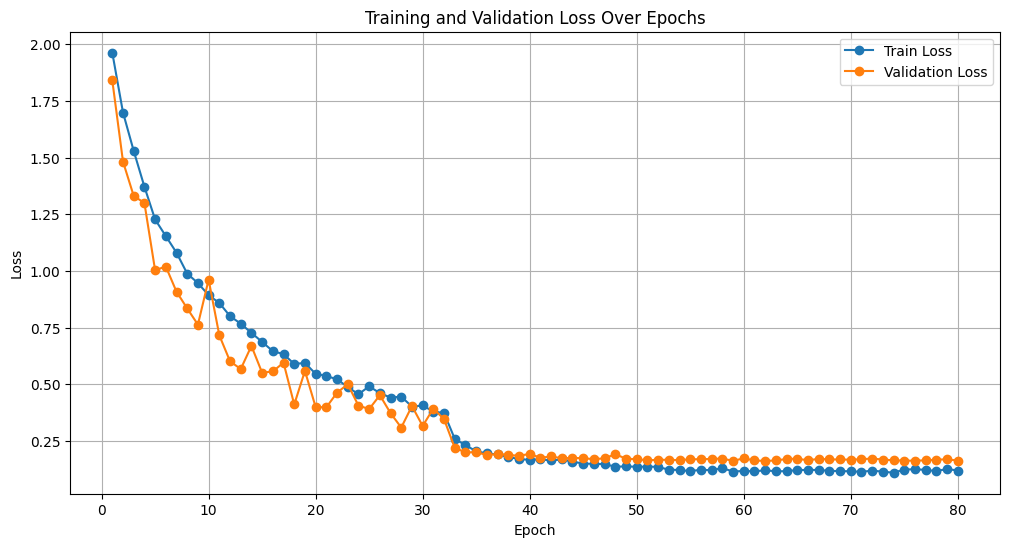

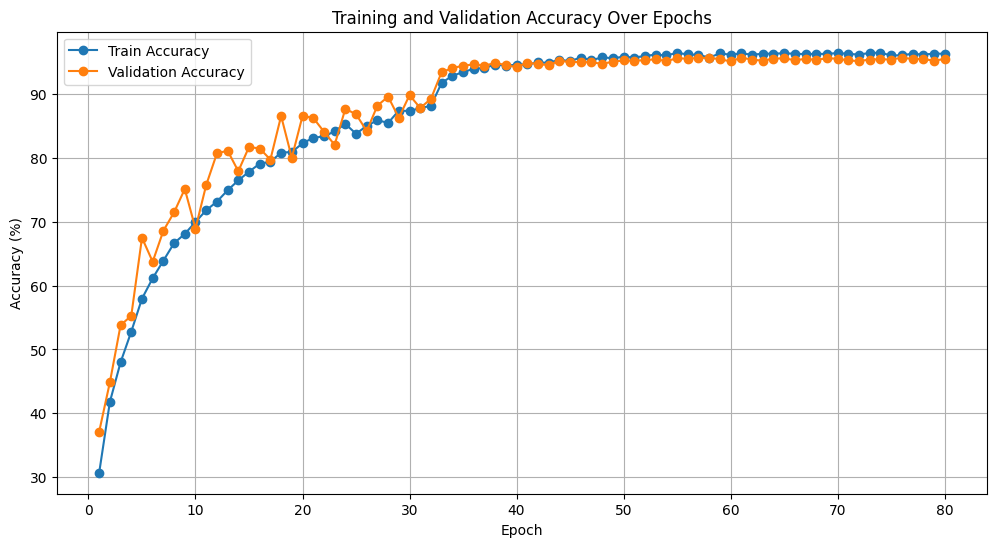

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training history
training_history = pd.read_csv('training_history.csv')

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(training_history['epoch'], training_history['train_loss'], label='Train Loss', marker='o')
plt.plot(training_history['epoch'], training_history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(training_history['epoch'], training_history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(training_history['epoch'], training_history['val_acc'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()


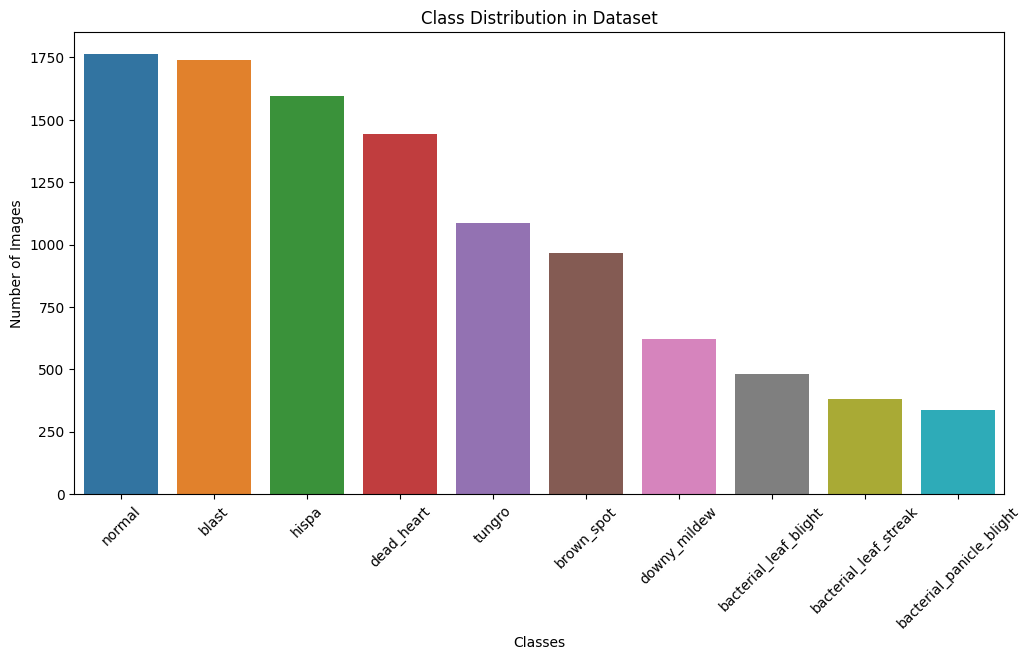

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset analysis
class_counts = full_dataset.data['label'].value_counts()

# Plot class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution in Dataset')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Generate confusion matrix and classification report for validation
def evaluate_model(model, loader, label_mapping, device):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix:\n', cm)

    # Classification report
    class_names = [label for label, idx in sorted(label_mapping.items(), key=lambda x: x[1])]
    report = classification_report(y_true, y_pred, target_names=class_names)
    print('\nClassification Report:\n', report)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

evaluate_model(model, val_loader, full_dataset.label_mapping, device)


Total images classified: 3469


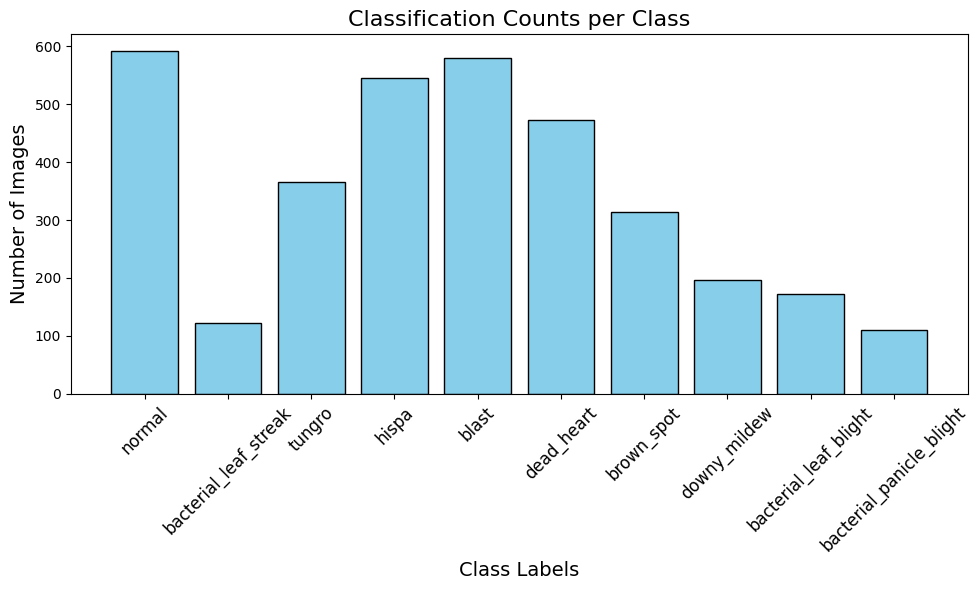

Classification results saved to classification_results.csv


In [10]:
import os
import torch
from torchvision import transforms
from PIL import Image
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Define test transformations (same as validation)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the trained model
def load_model(model_path, num_classes, device):
    model = CustomRiceNet(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path)['model_state_dict'])
    model = model.to(device)
    model.eval()  # Set to evaluation mode
    return model

# Function to classify test images and plot results
def classify_images(model, test_dir, label_mapping, device):
    results = []
    class_counts = Counter()  # To track the count of predictions for each class
    
    image_files = [f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    total_images = len(image_files)  # Total number of valid image files
    print(f"Total images found: {total_images}")
    
    for image_name in image_files:
        image_path = os.path.join(test_dir, image_name)

        # Load and preprocess image
        img = Image.open(image_path).convert('RGB')
        img = test_transforms(img).unsqueeze(0).to(device)

        # Get model predictions
        with torch.no_grad():
            outputs = model(img)
            _, predicted_idx = torch.max(outputs, 1)

        # Map index to label
        predicted_label = {v: k for k, v in label_mapping.items()}[predicted_idx.item()]
        results.append({'image': image_name, 'predicted_label': predicted_label})

        # Increment class count
        class_counts[predicted_label] += 1

    # Print summary statistics
    print(f"Total images classified: {len(results)}")

    # Plot classification counts
    labels, counts = zip(*class_counts.items())
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color='skyblue', edgecolor='black')
    plt.title("Classification Counts per Class", fontsize=16)
    plt.xlabel("Class Labels", fontsize=14)
    plt.ylabel("Number of Images", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.tight_layout()
    plt.savefig("classification_counts_plot.png")  # Save the plot as a file
    plt.show()

    return results

# Main function
def main():
    # Configuration
    test_dir = '/kaggle/input/paddydoctor/test_images'  # Path to test image directory
    model_path = 'best_custom_rice_model.pth'  # Path to trained model
    csv_file = '/kaggle/input/paddydoctor/train.csv'  # Path to CSV used for training

    # Load label mapping
    data = pd.read_csv(csv_file)
    label_mapping = {label: idx for idx, label in enumerate(data['label'].unique())}

    # Device setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # Load model
    model = load_model(model_path, num_classes=len(label_mapping), device=device)

    # Classify test images
    results = classify_images(model, test_dir, label_mapping, device)

    # Save results to CSV
    output_csv = 'classification_results.csv'
    pd.DataFrame(results).to_csv(output_csv, index=False)
    print(f"Classification results saved to {output_csv}")

if __name__ == '__main__':
    main()
